# Time period and sigma

### Author: Chris Wyburn-Powell, [github](https://github.com/chrisrwp/synthetic-ensemble/SIA/Time_period_and_sigma.ipynb)

**Input**: <br>
Sea ice area for 6 CLIVAR LE models and observations from HadISST1. <br>

**Output**: <br>
- $\sigma_{LE}$, $\sigma_{mem}$ and $\sigma_{obs}$ using a range of different time period lengths from 6 year to the full length of the linear trend

**Method**: <br>
- Identify a linear trend by eye for a decline in sea ice area

**TO DO**: <br>
- Find out how to objectively determine the best linear trend

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import math as m
import xarray as xr
import datetime
import dask
print(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d"))

data_path = '/glade/scratch/cwpowell/Synthetic_ensemble/'

22:18 UTC Fri 2021-07-16


In [102]:
# from dask_jobqueue import PBSCluster
# from dask.distributed import Client

# cluster = PBSCluster(cores    = 1,
#                      memory   = '10GB',
#                      queue    = 'economy',
#                      walltime = '00:29:00')

# cluster.scale(8)
# client = Client(cluster)
# client

In [2]:
model_names        = ['CanESM2', 'CESM1', 'CSIRO_MK36',  'GFDL_CM3', 'GFDL_ESM2M', 'MPI_ESM1']
model_print_names  = ['CanESM2', 'CESM1', 'CSIRO MK3.6', 'GFDL CM3', 'GFDL ESM2M', 'MPI ESM1']
obs_names          = ['HadISST1']
mem_len   = [50,  40,  30,  20,  30,  100]
start_yrs = [1950,1920,1850,1920,1950,1850]
colors    = ['m', 'b', 'g', 'orange', 'k', 'tab:olive']

## Load SIA data from models and observations

In [3]:
HadISST1_areas = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST_ice_area.nc')
HadISST1_SIC = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST_ice.nc')

HadISST_NH = HadISST1_SIC['sic'].where(HadISST1_SIC['latitude']>30, drop=True)

HadISST_SIA = []
for month_ in np.arange(1,13):
    HadISST_SIA.append((HadISST_NH.sel(time=HadISST_NH['time.month']==month_) * HadISST1_areas.where(HadISST1_areas['latitude']>30,drop=True)).sum('latitude').sum('longitude'))
    
HadISST_SIA = xr.concat(HadISST_SIA, dim='time')
HadISST_SIA = HadISST_SIA/1e12
HadISST_SIA = HadISST_SIA.rename({'cell_area': 'SIA'})
HadISST_SIA = HadISST_SIA.sortby('time')

HadISST1_SIA_79_20 = xr.open_dataset(data_path+'Raw_data/observations/HadISST/HadISST1_SIA_SIE_79-20_filled.nc')

Had_SIA = xr.concat((HadISST_SIA.sel(time=slice('1920-01', '1999-12')), HadISST1_SIA_79_20.sel(time=slice('2000-01','2020-12'))), dim='time')
Had_SIA = Had_SIA['SIA']

In [4]:
#load the SIA from models 1850-2100
SIA_models = xr.open_dataset(data_path+'SIA/SIA_SIE_SIV/CLIVAR_SIA_1850_2100_RCP85.nc')

# Test different ways of obtaining the dates for the linear trend

In [111]:
CanESM2_09 = SIA_models['CanESM2'].sel(time=SIA_models['time.month']==9).mean('member').sel(time=slice('1950','2100'))

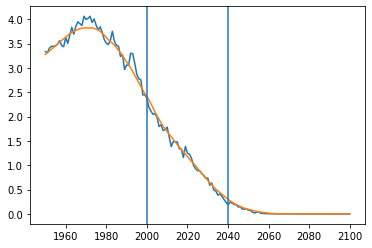

In [114]:
plt.plot(np.arange(1950,2101), CanESM2_09.values)
plt.plot(np.arange(1950,2101), sig.savgol_filter(CanESM2_09.values, 21, 1))

plt.axvline(2000)
plt.axvline(2040)

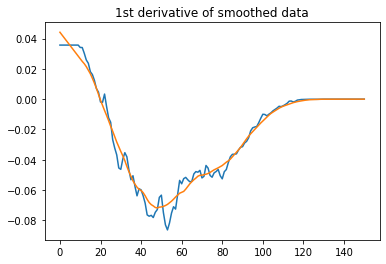

In [117]:
CanESM2_09_filt = sig.savgol_filter(CanESM2_09.values, 21, 1)
CanESM2_09_filt_grad = np.gradient(CanESM2_09_filt)
CanESM2_09_filt_grad_filt = sig.savgol_filter(CanESM2_09_filt_grad, 21,1)
plt.plot(CanESM2_09_filt_grad)
plt.plot(CanESM2_09_filt_grad_filt);
plt.title('1st derivative of smoothed data');

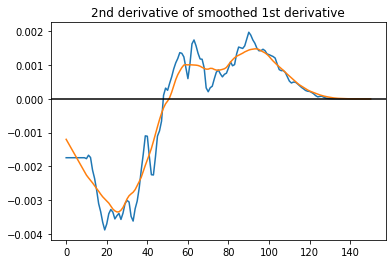

In [116]:
CanESM2_09_filt_grad_filt_grad = np.gradient(CanESM2_09_filt_grad_filt)
CanESM2_09_filt_grad_filt_grad_filt = sig.savgol_filter(CanESM2_09_filt_grad_filt_grad, 21, 1)
plt.plot(CanESM2_09_filt_grad_filt_grad)
plt.plot(CanESM2_09_filt_grad_filt_grad_filt)
plt.axhline(0, c='k')
plt.title('2nd derivative of smoothed 1st derivative');

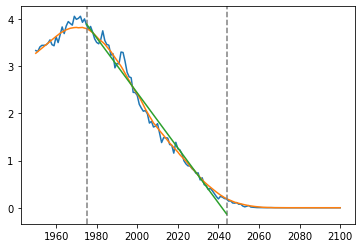

In [118]:
model_name = 'CanESM2'
model_i = 0
month_ = 9

SIA_model = SIA_models[model_name].sel(time=SIA_models['time.month']==month_).mean('member').sel(time=slice(str(start_yrs[model_i]),'2100'))

full_yrs = np.arange(start_yrs[model_i],2101)

plt.plot(full_yrs, SIA_model.values)
plt.plot(full_yrs, sig.savgol_filter(SIA_model.values, 21, 1))

model_filt_2nd =  sig.savgol_filter(np.gradient(sig.savgol_filter(np.gradient(sig.savgol_filter(SIA_model.values,21,1)), 21,1)), 21,1)
                                                                                                 
max_2nd = np.argmax(model_filt_2nd)
min_2nd = np.argmin(model_filt_2nd)

plt.axvline(full_yrs[max_2nd], c='0.5', linestyle='--')
plt.axvline(full_yrs[min_2nd], c='0.5', linestyle='--')

lin_x_vals = np.arange(full_yrs[min_2nd], full_yrs[max_2nd]+1, 1)

lin_coef = np.polyfit(lin_x_vals, SIA_model.isel(time=slice(min_2nd, max_2nd+1)).values, 1)
plt.plot(lin_x_vals, lin_coef[0]*lin_x_vals + lin_coef[1])

# Brute force - find optimal linear trend minimum of 40 years

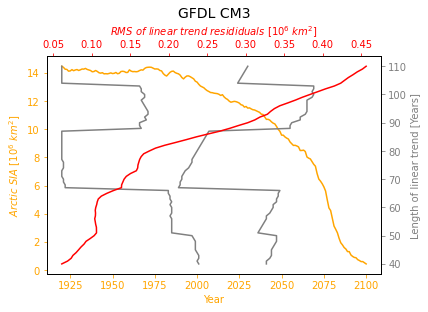

In [99]:
model_i = 3
model_name = model_names[model_i]
month_ = 3

trend_intervals = np.arange(40,111)

SIA_data = SIA_models[model_name].sel(time=SIA_models['time.month']==month_).mean('member').sel(time=slice(str(start_yrs[model_i]),'2100'))
full_yrs = np.arange(start_yrs[model_i],2101)

best_start = []
best_rms = []

for trend_interval in trend_intervals:
    trend_interval_rms = []
    for i in range(len(SIA_data)-trend_interval-1):
        #make a linear trend for 0th to trend_interval, then 1st to trend_interval+1.....
        coefs = np.polyfit(full_yrs[i:i+trend_interval], SIA_data.isel(time=slice(i, i+trend_interval)).values, 1)
        trend = (full_yrs[i:i+trend_interval] * coefs[0]) + coefs[1]
        #compute the residuals from the linear trend
        residuals = SIA_data.isel(time=slice(i, i+trend_interval)).values - trend
        #append the root mean square (rms) of the detrended data
        trend_interval_rms.append(np.sqrt(np.mean(residuals**2)))

    best_start.append(np.argmin(trend_interval_rms))
    best_rms.append(np.min(trend_interval_rms))
        

##### make a summary plot for that month and model #####
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twiny()
ax1.plot(full_yrs, SIA_data, c=colors[model_i])
ax1.set_ylabel(r'$Arctic \ SIA \ [10^6 \ km^2]$', color=colors[model_i])
ax1.set_xlabel('Year', color=colors[model_i])
ax1.tick_params(axis='both', colors=colors[model_i])

ax2.plot(np.array(best_start) + start_yrs[model_i], trend_intervals, c='0.5')
ax2.plot(np.array(best_start) + start_yrs[model_i] + trend_intervals, trend_intervals, c='0.5')
ax2.tick_params(axis='y', colors='0.5')
ax2.set_ylabel('Length of linear trend [Years]', color='0.5')

ax3.plot(best_rms, trend_intervals, c='r')
ax3.tick_params(axis='x', colors='r')
ax3.set_xlabel(r'$RMS \ of \ linear \ trend \ resididuals \ [10^6 \ km^2]$', color='r')

plt.title(model_print_names[model_i], fontsize=14);

0.2691674653002382


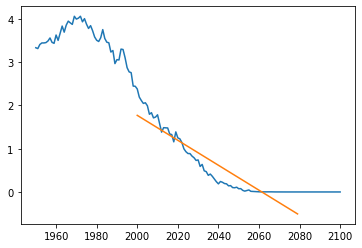

In [29]:
#test out the linear trend for a given trend_interval, model, month, and start element
model_name = 'CanESM2'
model_i = 0

month_ = 9

SIA_data = SIA_models[model_name].sel(time=SIA_models['time.month']==month_).mean('member').sel(time=slice(str(start_yrs[model_i]),'2100'))
full_yrs = np.arange(start_yrs[model_i],2101)

trend_interval = 80
i = 50

coefs = np.polyfit(full_yrs[i:i+trend_interval], SIA_data.isel(time=slice(i, i+trend_interval)).values, 1)
trend = (full_yrs[i:i+trend_interval] * coefs[0]) + coefs[1]
plt.plot(full_yrs, SIA_data.values)
plt.plot(full_yrs[i:i+trend_interval], trend)

residuals = SIA_data.isel(time=slice(i, i+trend_interval)).values - trend
rms = np.sqrt(np.mean(residuals**2))
print(rms)

# Detrend the SIA relative to the ensemble mean for the chosen linear trend

## Define the linear trend limits for March and September

In [13]:
#select the longest linear trend for each model for September and March, also observations
March_linear     = [[1982,2065], [2015,2090], [1977,2054], [1985,2044], [1970,2040], [1970,2067], [1953,2020]]
September_linear = [[1972,2032], [1995,2045], [1985,2044], [1985,2028], [1970,2040], [1985,2045], [1965,2020]]

Mar_linear_xr = xr.DataArray(data=March_linear, coords={'dataset': model_names+obs_names, 'limit': ['start', 'end']}, dims=['dataset', 'limit'])
Sep_linear_xr = xr.DataArray(data=September_linear, coords={'dataset': model_names+obs_names, 'limit': ['start', 'end']}, dims=['dataset', 'limit'])

linear_trend_dates = xr.Dataset({'03': Mar_linear_xr, '09':Sep_linear_xr})

## Detrend based on thses dates

In [14]:
def detrend_ens_ind(data, start_yr, end_yr, mem_len):
    '''
    detrends relative to the ensemble mean and the individual member
    '''

    #detrend with ensemble mean 
    coefs = np.polyfit(np.arange(start_yr,end_yr+1), data.mean('member').values, 1)
    ens_trend = xr.DataArray(data=(np.arange(start_yr,end_yr+1)*coefs[0])+coefs[1], coords={'time':data['time']}, dims='time')
    anomalies_ens = data - ens_trend

    #detrend individual members
    anomalies_ind = []
    for mem_i, mem in enumerate(np.arange(1,mem_len+1)):
        coefs = np.polyfit(np.arange(start_yr,end_yr+1), data.sel(member=mem).values, 1)
        tred_ind = (np.arange(start_yr, end_yr+1) * coefs[0]) + coefs[1]
        anomalies_ind.append(xr.DataArray(data=data.sel(member=mem)-tred_ind, coords={'time':data['time']}, dims='time'))

    anomalies_ind = xr.concat((anomalies_ind), dim='member')
    anomalies_ind['member'] = np.arange(1,mem_len+1)

    return(anomalies_ens, anomalies_ind)

In [15]:
#detrend all model members
all_detrended_ens = []
all_detrended_ind = []

for model_i, model_name in enumerate(model_names):

    model_detrended_ens = []
    model_detrended_ind = []

    for month_ in [3,9]:

        start_yr = linear_trend_dates[str(month_).zfill(2)].sel(dataset=model_name).sel(limit='start')
        end_yr   = linear_trend_dates[str(month_).zfill(2)].sel(dataset=model_name).sel(limit='end')
        data_ = SIA_models[model_name].sel(time=SIA_models['time.month']==month_).sel(time=slice(str(start_yr.values), str(end_yr.values))).sel(member=slice(0,mem_len[model_i]))

        detrend_temp = detrend_ens_ind(data_, start_yr, end_yr, mem_len[model_i])

        model_detrended_ens.append(detrend_temp[0])
        model_detrended_ind.append(detrend_temp[1])

    all_detrended_ens.append(xr.concat((model_detrended_ens), dim='time'))
    all_detrended_ind.append(xr.concat((model_detrended_ind), dim='time'))

all_detrended_ens = xr.concat((all_detrended_ens), dim='model')
all_detrended_ind = xr.concat((all_detrended_ind), dim='model')

all_detrended_ens['model'] = model_names
all_detrended_ind['model'] = model_names

In [16]:
#detrend observations
obs_detrend = []

for month_ in [3,9]:
    
    start_yr = linear_trend_dates[str(month_).zfill(2)].sel(dataset='HadISST1').sel(limit='start')    
    end_yr   = linear_trend_dates[str(month_).zfill(2)].sel(dataset='HadISST1').sel(limit='end')    
    obs = Had_SIA.sel(time=Had_SIA['time.month']==month_).sel(time=slice(str(start_yr.values), str(end_yr.values)))
    
    coefs = np.polyfit(np.arange(start_yr,end_yr+1), obs.values, 1)
    obs_trend = xr.DataArray(data=(np.arange(start_yr,end_yr+1)*coefs[0])+coefs[1], coords={'time':obs['time']}, dims='time')
    
    obs_detrend.append(obs - obs_trend)

obs_detrend = xr.concat((obs_detrend), dim='time')

# Calculate $\sigma_{LE}$, $\sigma_{mem}$, $\sigma_{obs}$ for multiple time periods

In [17]:
def resample_boot2(data, resample_n):
    
    '''
    Returns resamplings of a given time series of length equal to time period 
    '''
    boot_2_first_ind = xr.DataArray(data   = np.random.randint(0,len(data)-2, (resample_n,int(len(data)/2))), 
                                    coords = {'resampling':np.arange(1,resample_n+1), 'year_i':np.arange(1,len(data)+1,2)},
                                    dims   = ['resampling', 'year_i'])

    boot_2_second_ind = (boot_2_first_ind+1).copy()
    boot_2_second_ind['year_i'] = np.arange(2,len(data)+2,2)

    all_boot_2_ind = xr.concat((boot_2_first_ind, boot_2_second_ind), dim='year_i').sortby('year_i')
    
    ind_base = np.repeat(np.arange(0,len(data)*resample_n,len(data)),len(data))
    
    ind_1_d = np.ravel(all_boot_2_ind) + ind_base

    SIA_mem_1000 = np.ravel(np.tile(data,(len(data),resample_n)))

    resample_boot_2 = xr.DataArray(data = np.reshape(SIA_mem_1000[ind_1_d], (len(data),resample_n)),
                                   coords = {'year_i':np.arange(1,len(data)+1,1), 'resampling':np.arange(1,resample_n+1,1)},
                                   dims   = ['year_i', 'resampling'])

    return(resample_boot_2.std('year_i').std('resampling'))

## $\sigma_{mem}$

In [12]:
#calculate sigma_mem via resampling and use dask
#firstly define a function for each of the members

def member_resample(member_data, mem):
    
    data_ = member_data[~np.isnan(member_data)]

    model_member_time_resampled = []
    for time_period in np.arange(6,len(data_)-1,2):

        all_runs = []
        for run_ in range(20):
            rand_start = np.random.randint(0,len(data_)-time_period-1) + int(str(data_['time'][0].values)[:4])
            all_runs.append(resample_boot2(data_.sel(time=slice(str(rand_start),str(rand_start+time_period-1))), 1000))

        all_runs = xr.concat((all_runs), dim='run')    
        model_member_time_resampled.append(all_runs.mean('run'))

    return(xr.concat((model_member_time_resampled), dim='time_period'))

In [100]:
# #calculate sigma_mem
# month_ = 9

# sigma_mem_ = {}
# for model_i, model_name in enumerate(model_names):
#     print(datetime.datetime.now(), model_name)
    
#     model_data = all_detrended_ens.sel(model=model_name).sel(time=all_detrended_ens['time.month']==month_)
#     max_t_period = len(model_data.sel(member=1)[~np.isnan(model_data).sel(member=1)]['time'])
    
#     model_resampled = []
#     for mem in np.arange(1,mem_len[model_i]+1):
#         model_resampled.append(dask.delayed(member_resample)(model_data.sel(member=mem), mem))
        
#     resampled_computed = dask.compute(*model_resampled)
    
#     model_resampled = xr.concat((resampled_computed), 'member')
#     model_resampled['time_period'] = np.arange(6,max_t_period-1,2)
#     model_resampled['member'] = np.arange(1,mem_len[model_i]+1)
    
#     sigma_mem_[model_name] = model_resampled
    
# sigma_mem_ = xr.Dataset(sigma_mem_)

In [ ]:
# #save sigma_mem to netcdf
# sigma_mem.attrs = {'Description': 'Resampled standard deviations of Arctic sea ice area for six models (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Time periods are Septembers for 6-maximum years along a linear trend of sea ice area decline during historical and/or RCP8.5. Start dates within the linear trend are chosen at random 20 times and the results averaged. Models are resampled 1000 times with a 2 year bootstrap size.',
#                    'Units'      : 'Million square km',
#                    'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
#                    'Data source': 'CLIVAR Large Ensemble Archive (doi: 10.1038/s41558-020-0731-2)',
#                    'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/obs-ensemble/Time_period_and_sigma.ipynb'}

# sigma_mem.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_mem_ensemble_linear_trend_time_period_09.nc')

In [90]:
#calculate sigma_mem
month_ = 3

sigma_mem = {}
for model_i, model_name in enumerate(model_names):
    print(datetime.datetime.now(), model_name)
    
    model_member_resampled = []
    for mem in np.arange(1,mem_len[model_i]+1):
    
        data_with_nan = all_detrended_ens.sel(model=model_name).sel(member=mem).sel(time=all_detrended_ens['time.month']==month_)
        data_ = data_with_nan[~np.isnan(data_with_nan)]

        model_member_time_resampled = []
        for time_period in np.arange(6,len(data_)-1,2):

            all_runs = []
            for run_ in range(10):
                rand_start = np.random.randint(0,len(data_)-time_period-1) + int(str(data_['time'][0].values)[:4])
                all_runs.append(resample_boot2(data_.sel(time=slice(str(rand_start),str(rand_start+time_period-1))), 1000))

            all_runs = xr.concat((all_runs), dim='run')    
            model_member_time_resampled.append(all_runs.mean('run'))
    
        model_member_resampled.append(xr.concat((model_member_time_resampled), dim='time_period'))
            
    model_resampled = xr.concat((model_member_resampled), 'member')
    model_resampled['time_period'] = np.arange(6,len(data_)-1,2)
    model_resampled['member'] = np.arange(1,mem_len[model_i]+1)
    
    sigma_mem[model_name] = model_resampled

2021-07-16 11:03:10.211558 CanESM2
2021-07-16 11:06:38.591546 CESM1
2021-07-16 11:08:57.071489 CSIRO_MK36
2021-07-16 11:10:48.858903 GFDL_CM3
2021-07-16 11:11:34.874152 GFDL_ESM2M
2021-07-16 11:13:03.812821 MPI_ESM1


In [91]:
#save sigma_mem to netcdf
sigma_mem = xr.Dataset(sigma_mem)

sigma_mem.attrs = {'Description': 'Resampled standard deviations of Arctic sea ice area for six models (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Time periods are March for 6-maximum years along a linear trend of sea ice area decline during historical and/or RCP8.5. Start dates within the linear trend are chosen at random 10 times and the results averaged. Models are resampled 1000 times with a 2 year bootstrap size.',
                   'Units'      : 'Million square km',
                   'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                   'Data source': 'CLIVAR Large Ensemble Archive (doi: 10.1038/s41558-020-0731-2)',
                   'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/obs-ensemble/Time_period_and_sigma.ipynb'}

sigma_mem.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_mem_ensemble_linear_trend_time_period_03.nc')

## $\sigma_{LE}$

In [27]:
#calculate sigma_LE
month_ = 3

sigma_LE = {}

for model_i, model_name in enumerate(model_names):
    print(datetime.datetime.now(), model_name)
    
    data_reduced_time = []
    
    all_mem = all_detrended_ens.sel(model=model_name).sel(time=all_detrended_ens['time.month']==month_)
    mem_1_no_nan = all_mem.sel(member=1)[~np.isnan(all_mem.sel(member=1))]    
    
    for time_period in np.arange(6,len(mem_1_no_nan)-1,2):
        
        runs = []
        for run in range(1000):
            rand_start = np.random.randint(0,len(mem_1_no_nan)-time_period-1) 
            runs.append(all_mem.isel(time=slice(rand_start,rand_start+time_period-1)).std('time'))
        
        data_reduced_time.append(xr.concat((runs), dim='run').mean('run'))
    
    sigma_LE[model_name] = xr.concat((data_reduced_time), dim='time_period').std('member').drop('model')
    sigma_LE[model_name]['time_period'] = np.arange(6,len(mem_1_no_nan)-1,2)
    
sigma_LE = xr.Dataset(sigma_LE)

2021-07-16 10:33:30.840688 CanESM2
2021-07-16 10:34:01.075040 CESM1
2021-07-16 10:34:28.866452 CSIRO_MK36
2021-07-16 10:34:56.734293 GFDL_CM3
2021-07-16 10:35:17.555643 GFDL_ESM2M
2021-07-16 10:35:42.341627 MPI_ESM1


In [28]:
#save sigma_LE to netcdf
sigma_LE.attrs = {'Description': 'Standard deviations (between members) of Arctic sea ice area for six models (CanESM2, CESM1, CSIRO MK3.6, GFDL CM3, GFDL ESM2M, MPI ESM1). Time periods are March for 6-maximum years along a linear trend of sea ice area decline during historical and/or RCP8.5. Start dates within the linear trend are chosen at random 1000 times and the results averaged.',
                  'Units'      : 'Million square km',
                  'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                  'Data source': 'CLIVAR Large Ensemble Archive (doi: 10.1038/s41558-020-0731-2)',
                  'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/obs-ensemble/Time_period_and_sigma.ipynb'}

sigma_LE.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_LE_ensemble_linear_trend_time_period_03.nc')

## $\sigma_{obs}$

In [29]:
#calculate sigma_obs
sigma_obs = []

for month_ in np.arange(1,13):

    obs = obs_detrend.sel(time=obs_detrend['time.month']==month_)

    resampled_reduced_time = []
    for time_period in np.arange(6,len(obs)-1,2):
        if time_period % 6 == 0:
            print(datetime.datetime.now(), time_period)

        runs = []
        for run in range(1000):

            rand_start = np.random.randint(0,len(obs)-time_period-1) 
            runs.append(resample_boot2(obs.isel(time=slice(rand_start,rand_start+time_period)), 1000))

        resampled_reduced_time.append(xr.concat((runs), dim='run').mean('run'))

    sigma_obs = xr.concat((resampled_reduced_time), dim='time_period')
    sigma_obs['time_period'] = np.arange(6,len(obs)-1,2)

2021-07-16 10:37:02.500032 6
2021-07-16 10:37:17.976659 12
2021-07-16 10:37:33.989098 18
2021-07-16 10:37:50.954637 24
2021-07-16 10:38:08.618735 30
2021-07-16 10:38:26.844332 36
2021-07-16 10:38:46.602074 42
2021-07-16 10:39:07.368028 48
2021-07-16 10:39:29.160181 54
2021-07-16 10:39:52.532350 60
2021-07-16 10:40:21.609576 66


In [30]:
#save sigma_obs to netcdf
sigma_obs.attrs = {'Description': 'Resampled standard deviations of observed Arctic sea ice area for HadISST1. Time periods are March for 6-maximum years along a linear trend of sea ice area decline. Start dates within the linear trend are chosen at random 1000 times and the results averaged. The resamplings are also taken 1000 times and a 2 year bootstrap size is used.',
                   'Units'      : 'Million square km',
                   'Timestamp'  : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),                
                   'Data source': 'HadISST1 (doi: 10.1029/2002JD002670)',
                   'Analysis'   : 'Python 3.7.9 - https://github.com/chrisrwp/obs-ensemble/Time_period_and_sigma.ipynb'}

sigma_obs.to_netcdf(data_path+'SIA/SIA_resampled/Sigma_obs_linear_trend_time_period_03.nc')

# Plot $\sigma_{LE}$, $\sigma_{mem}$, $\sigma_{obs}$ and their ratios

In [92]:
#load the appropriate sigma files from NetCDF
sigma_LE_03 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_LE_ensemble_linear_trend_time_period_03.nc')
sigma_LE_09 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_LE_ensemble_linear_trend_time_period_09.nc')

sigma_mem_03 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_ensemble_linear_trend_time_period_03.nc')
sigma_mem_09 = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_ensemble_linear_trend_time_period_09.nc')

sigma_obs_03 = xr.open_dataarray(data_path+'SIA/SIA_resampled/Sigma_obs_linear_trend_time_period_03.nc')
sigma_obs_09 = xr.open_dataarray(data_path+'SIA/SIA_resampled/Sigma_obs_linear_trend_time_period_09.nc')

### $\sigma_{LE}$ with time period

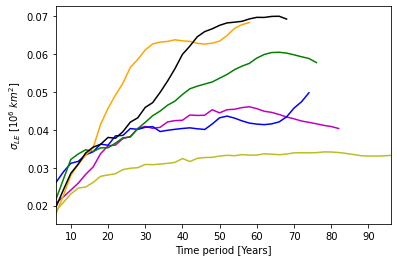

In [99]:
for model_i, model_name in enumerate(model_names):
    sigma_LE_03[model_name].plot(c=colors[model_i], label=model_print_names[model_i])
    
plt.ylabel(r'$\sigma_{LE} \ [10^6 \ km^2]$')
plt.xlabel('Time period [Years]')
plt.xlim(6,96);

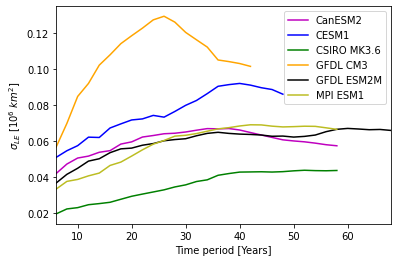

In [39]:
for model_i, model_name in enumerate(model_names):
    sigma_LE_09[model_name].plot(c=colors[model_i], label=model_print_names[model_i])
    
plt.ylabel(r'$\sigma_{LE} \ [10^6 \ km^2]$')
plt.xlabel('Time period [Years]')
plt.xlim(6,68)
plt.legend();

### $\sigma_{mem}$ and $\sigma_{obs}$ with time period

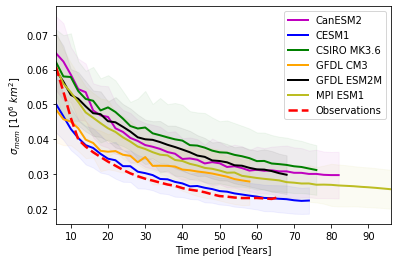

In [98]:
for model_i, model_name in enumerate(model_names):
    sigma_mem_03[model_name].mean('member').plot(c=colors[model_i], linewidth=2, label=model_print_names[model_i])
    plt.fill_between(sigma_mem_03[model_name]['time_period'], sigma_mem_03[model_name].mean('member')-sigma_mem_03[model_name].std('member'), 
                    sigma_mem_03[model_name].mean('member')+sigma_mem_03[model_name].std('member'), color=colors[model_i], alpha=0.05)

sigma_obs_03.plot(c='r', label='Observations', linestyle='--', linewidth=2.5)

plt.ylabel(r'$\sigma_{mem} \ [10^6 \ km^2]$')
plt.xlabel('Time period [Years]')
plt.xlim(6,96)
plt.legend();

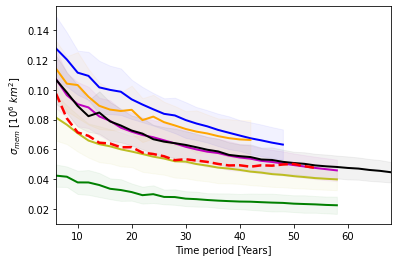

In [100]:
for model_i, model_name in enumerate(model_names):
    sigma_mem_09[model_name].mean('member').plot(c=colors[model_i], linewidth=2, label=model_print_names[model_i])
    plt.fill_between(sigma_mem_09[model_name]['time_period'], sigma_mem_09[model_name].mean('member')-sigma_mem_09[model_name].std('member'), 
                    sigma_mem_09[model_name].mean('member')+sigma_mem_09[model_name].std('member'), color=colors[model_i], alpha=0.05)

sigma_obs_09.plot(c='r', label='Observations', linestyle='--', linewidth=2.5)

plt.ylabel(r'$\sigma_{mem} \ [10^6 \ km^2]$')
plt.xlabel('Time period [Years]')
plt.xlim(6,68);
# plt.legend();

### Ratio $\sigma_{mem}$ to $\sigma_{LE}$ with time period

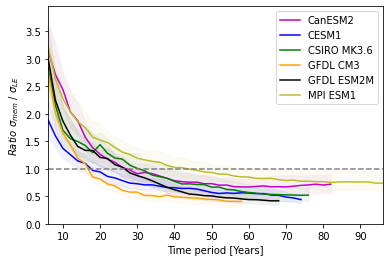

In [101]:
for model_i, model_name in enumerate(model_names):

    (sigma_mem_03[model_name].median('member') / sigma_LE_03[model_name]).plot(c=colors[model_i], label=model_print_names[model_i])

    plt.fill_between(sigma_mem_03[model_name]['time_period'], (sigma_mem_03[model_name].mean('member')-sigma_mem_03[model_name].std('member'))/sigma_LE_03[model_name], 
                    (sigma_mem_03[model_name].mean('member')+sigma_mem_03[model_name].std('member'))/sigma_LE_03[model_name], color=colors[model_i], alpha=0.05)

plt.axhline(1, c='0.5', linestyle='--')
    
plt.ylabel(r'$Ratio \ \sigma_{mem} \ / \ \sigma_{LE}$')
plt.xlabel('Time period [Years]')
plt.xlim(6,96)
plt.ylim(bottom=0)
plt.legend();

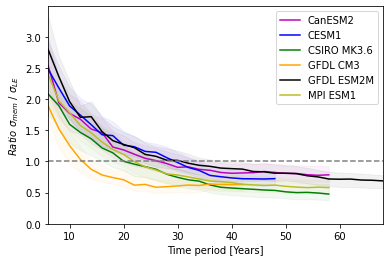

In [79]:
for model_i, model_name in enumerate(model_names):

    (sigma_mem_09[model_name].median('member') / sigma_LE_09[model_name]).plot(c=colors[model_i], label=model_print_names[model_i])

    plt.fill_between(sigma_mem_09[model_name]['time_period'], (sigma_mem_09[model_name].mean('member')-sigma_mem_09[model_name].std('member'))/sigma_LE_09[model_name], 
                    (sigma_mem_09[model_name].mean('member')+sigma_mem_09[model_name].std('member'))/sigma_LE_09[model_name], color=colors[model_i], alpha=0.05)

plt.axhline(1, c='0.5', linestyle='--')
    
plt.ylabel(r'$Ratio \ \sigma_{mem} \ / \ \sigma_{LE}$')
plt.xlabel('Time period [Years]')
plt.xlim(6,68)
plt.ylim(bottom=0)
plt.legend();

### Ratio $\sigma_{mem}$ to $\sigma_{obs}$ with time period

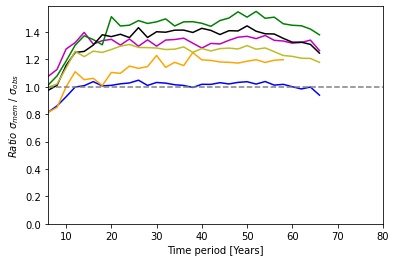

In [102]:
for model_i, model_name in enumerate(model_names):

    (sigma_mem_03[model_name].median('member') / sigma_obs_03).plot(c=colors[model_i], label=model_print_names[model_i])

#     plt.fill_between(sigma_mem_09[model_name]['time_period'], (sigma_mem_09[model_name].mean('member')-sigma_mem_09[model_name].std('member'))/sigma_obs_09, 
#                     (sigma_mem_09[model_name].mean('member')+sigma_mem_09[model_name].std('member'))/sigma_obs_09, color=colors[model_i], alpha=0.05)

plt.axhline(1, c='0.5', linestyle='--')
    
plt.ylabel(r'$Ratio \ \sigma_{mem} \ / \ \sigma_{obs}$')
plt.xlabel('Time period [Years]')
plt.xlim(6,80)
plt.ylim(bottom=0);
# plt.legend();

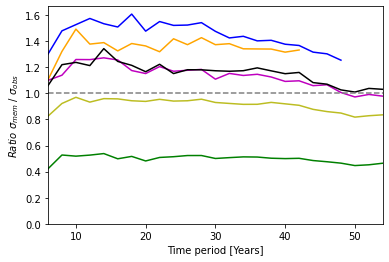

In [89]:
for model_i, model_name in enumerate(model_names):

    (sigma_mem_09[model_name].median('member') / sigma_obs_09).plot(c=colors[model_i], label=model_print_names[model_i])

#     plt.fill_between(sigma_mem_09[model_name]['time_period'], (sigma_mem_09[model_name].mean('member')-sigma_mem_09[model_name].std('member'))/sigma_obs_09, 
#                     (sigma_mem_09[model_name].mean('member')+sigma_mem_09[model_name].std('member'))/sigma_obs_09, color=colors[model_i], alpha=0.05)

plt.axhline(1, c='0.5', linestyle='--')
    
plt.ylabel(r'$Ratio \ \sigma_{mem} \ / \ \sigma_{obs}$')
plt.xlabel('Time period [Years]')
plt.xlim(6,54)
plt.ylim(bottom=0);
# plt.legend();